# CHANGE DETECTION - FORECASTING - FORECAST OF THE STATE OF RESTORATION
In this notebook, the algorithms and methods for the change detection, time series forecasting, and restoration state prediction phase of vegetation profiles are given.
The csv files obtained from the profile extraction scripts are used in this notebook.

To execute, run all blocks up to the FUNCTIONS section in FULL IMAGE ANALYSIS. Then follow the subsequent instructions.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

!pip install scikit-fda
!pip install GPy
!pip install git+https://github.com/JohnYKiyo/density_ratio_estimation.git
!pip install densratio
!pip install ruptures
!pip install nbeats-keras
!pip install gluonts[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-nyfb3deq
  Running command git clone --filter=blob:none --quiet https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-nyfb3deq
  Resolved https://github.com/ourownstory/neural_prophet.git to commit 81cbbfc3e9cba47ca5de68f0930e84eb22ebd963
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.5/706.5 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 KB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 

# IMPORTS

In [2]:
import pandas as pd
import numpy as np
import itertools
from PIL import Image
import glob
import datetime
import os
import seaborn as sns
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import matplotlib.pyplot as plt
import matplotlib.image as plimg
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from scipy import signal
from numpy.random import default_rng
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import DBSCAN
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from IPython.display import clear_output
from IPython.display import Image as Show
from neuralprophet import NeuralProphet


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector, Input, concatenate
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from skfda.representation.basis import BSpline, Fourier, Monomial

from densratio import densratio
import ruptures as rpt
from scipy.signal import find_peaks, find_peaks_cwt
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset

import cv2
import math

import io

np.random.seed(123)

time_unit = "week"
index = "ndvi"

# DATA LOADING FUNCTIONS
## load_dataset

Opens a csv and returns a pandas.Dataframe 


## split_dataset
PARAMS:


1.   df -> pandas.Dataframe returned by load_dataset
2.   threshold -> date in format "YYYY-mm-dd" or float between 0 and 1
3.   norm ->  boolean, enable/disable normalization
4.   normlog -> booleano, True = log normalization, False = standard scikit learn scaler (z-score)

RETURNS:


1.   normalized dataset
2.   normalized train (before threshold)
3.   normalized test  (post threshold)
4.   scalers (if normlog = False)





In [3]:
from traitlets.traitlets import Int

pd.options.mode.chained_assignment = None

def load_dataset(file):
  series = pd.DataFrame()
  series = pd.read_csv(file, header=0, parse_dates=["date"])
  # series.set_index('date', inplace=True)
  series.rename(columns = {'Unnamed: 0':time_unit}, inplace = True)
  return series

def split_dataset(df, threshold, norm, normlog):
  series = df.copy()
  scalers = []
  if norm:
    if normlog:
      '''log normalization'''
      i = 0
      while str(i) in series.columns:
        series[str(i)] = np.log(series[str(i)]+1)
        i+=1
    else:
      '''standard scaler normalization'''
      i = 0
      while str(i) in series.columns:
        scaler = StandardScaler()
        scaler.fit(series[[str(i)]])
        series[str(i)] = scaler.transform(series[[str(i)]])
        scalers.append(scaler)
        i+=1

  if isinstance(threshold, str):
    dftraining = series.loc[series['date'] <= threshold]
    dftest = series.loc[series['date'] > threshold]
  else:
    threshold = int(threshold * len(series))
    dftraining = series[:threshold]
    dftest = series[threshold:]

  
  return series, dftraining, dftest, scalers


# FORECASTING MODELS 



## PROPHET
Prophet of Meta
PARAMS:


1.   series -> pandas.Dataframe where the date column is renamed to “ds” and the value column to “y”
2.   periods -> Number of periods to be predicted (frequency can be changed to line 27, currently set to weekly frequency)
3.   params -> Dictionary provided with the following keys:



> 

    params = {
        "n_changepoints": int,
        "changepoints": [list of date] or None,
        "changepoint_range": 0<n<1,
        "changepoint_prior_scale": 20,
        "seasonality_prior_scale": 0.1,
        "growth": "logistic", "flat", "linear" (see documentation)
        "include_history": bool,
        "cap": number or None, (if None, cap and flor are calculated automatically)
        "floor": number or None,
    }

RETURNS:


1.   forecast dataframe



In [4]:
def run_prophet(series, periods, params):
  series.drop(series.columns.difference(["y","ds"]), 1, inplace=True)
  
  if params["cap"] is "auto":
    series['cap'] = series["y"].max()
    series['floor'] = series["y"].min()
  else:
    series['cap'] = params["cap"]
    series['floor'] = params["floor"]
  model = Prophet(
              yearly_seasonality=params["yearly_seasonality"],
              weekly_seasonality=False,
              daily_seasonality=False,
              seasonality_mode='additive',
              n_changepoints = params["n_changepoints"],
              changepoint_range = params["changepoint_range"],
              seasonality_prior_scale=params["seasonality_prior_scale"],
              holidays_prior_scale=0.0,
              changepoint_prior_scale=params["changepoint_prior_scale"],
              uncertainty_samples=0, # It is only used to calculate the uncertainty, default = 1000
              growth=params["growth"],
              changepoints=params["changepoints"],
  )

  # model.add_seasonality(name='yearly',period=365, fourier_order=10)
  model.fit(series)
  future = model.make_future_dataframe(periods=periods, freq="7D", include_history=params["include_history"])
  if params["cap"] is "auto":
    future['cap'] = series["y"].max()
    future['floor'] = series["y"].min()
  else:
    future['cap'] = params["cap"]
    future['floor'] = params["floor"]
  return model.predict(future)

WARNING - (py.warnings._showwarnmsg) - <>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?


WARNING - (py.warnings._showwarnmsg) - <>:28: SyntaxWarning: "is" with a literal. Did you mean "=="?


WARNING - (py.warnings._showwarnmsg) - <>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?


WARNING - (py.warnings._showwarnmsg) - <>:28: SyntaxWarning: "is" with a literal. Did you mean "=="?


WARNING - (py.warnings._showwarnmsg) - <ipython-input-4-5dc119fd06c5>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if params["cap"] is "auto":

  if params["cap"] is "auto":

WARNING - (py.warnings._showwarnmsg) - <ipython-input-4-5dc119fd06c5>:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if params["cap"] is "auto":

  if params["cap"] is "auto":



## NEURAL PROPHET
Extenstion of Prophet.

Same parameters and return values as Prophet.

The parameter dictionary requires the following keys:
>

    params= {
        "growth" : "linear", (see documentation)
        "n_changepoints" : int,
        "changepoint_range" : 0<n1,
        "trend_reg" : real,
        "changepoints" : [list of date] or None
    }


In [5]:
def run_neural_prophet(series, periods, params):
  series.drop(series.columns.difference(["y","ds"]), 1, inplace=True)
  model = NeuralProphet(
        growth = params["growth"],
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        changepoints_range=params["changepoint_range"],
        n_changepoints=params["n_changepoints"],
        trend_reg=params["trend_reg"],
        changepoints = params["changepoints"]
  )
  model.fit(series)
  future = model.make_future_dataframe(series, periods=periods, n_historic_predictions=params["include_history"])
  forecast = model.predict(future)
  forecast.rename(columns = {"yhat1":'yhat'}, inplace=True)
  return forecast

## HWES
Holt Winter Exponential Smoothing

Same parameters and return values as Prophet

The parameter dictionary requires the following keys:
>

    params = {
        "hwes_m" : units of time in a year (EG: if time unit = day -> hwes_m = 365),
        "include_history" : boolean, (inlcude or not the training data in the returned dataframe)
    }

In [6]:
def run_hwes(series, periods, params):
  seasonal_periods = params["seasonal_periods"]
  model = ExponentialSmoothing(series["y"],trend="add", damped_trend=True, seasonal="add", seasonal_periods=seasonal_periods).fit()
  past = model.fittedvalues
  future = model.forecast(periods)
  forecast = pd.DataFrame()
  if params["include_history"]:
    dates = pd.date_range(start=series["ds"].iloc[0], periods=periods+series.shape[0], freq=str(int(365/seasonal_periods))+"D")
    forecast["ds"] = dates
    forecast["yhat"] = np.append(past,future)
  else:
    dates = pd.date_range(start=series["ds"].iloc[-1], periods=periods, freq=str(int(365/seasonal_periods))+"D")
    forecast["ds"] = dates
    forecast["yhat"] = np.asarray(future)
  return forecast

## LSTM ENCODER DECODER
Functions to convert the time series to a supervisat task, train the LSTM Encoder Decoder model, and predict with multi step forecasting.

Same parameters and return values as Prophet

The parameter dictionary requires the following keys:

>

    params = {
        "backward_steps": int (backward step for prediction),
        "forward_steps" : int (step forward to be predicted),
        "epochs" : int,
        "batch_size": int
    }

In [7]:
def series_to_supervised(data, backward_steps=1, forward_steps=1, n_features=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(backward_steps, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, forward_steps):
      cols.append(df.shift(-i))
      if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  n_obs = backward_steps * n_features
  X = agg.values[:, :n_obs]
  y = agg.values[:, -forward_steps:]
  X = X.reshape((X.shape[0], backward_steps, n_features))
  y = y.reshape((y.shape[0], forward_steps, n_features))
  return X, y
# frame as supervised learning


def fit_lstm(X, y, backward_steps, forward_steps, n_features, epochs, batch_size):
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  with tf.device(device_name):
    model = Sequential()
    #ENCODER
    model.add(LSTM(80, activation='tanh', input_shape=(backward_steps, n_features), return_sequences=True))
    model.add(LSTM(30, activation='tanh', return_sequences=True))
    model.add(LSTM(10, activation='tanh'))

    model.add(RepeatVector(forward_steps))

    #DECODER
    model.add(LSTM(80, activation='tanh', return_sequences=True))
    model.add(LSTM(30, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=opt)
    # define early stopping parameter
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    # fit network
    history = model.fit(X, y, epochs=epochs, callbacks=[callback], batch_size=batch_size, verbose=2, shuffle=False)
    return model

def predict_lstm(model, x, backward_steps, forward_steps, n_features, steps):
  x = x.reshape(1, backward_steps, n_features)
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  with tf.device(device_name):
    yhat = []
    # FREE RUN prediction
    for i in range(steps):
      yhat_future = model.predict(x)
      yhat_future = yhat_future.reshape((len(yhat_future), forward_steps))
      # store forecast
      yhat = np.append(yhat, yhat_future)
      # shift to the left the observations and replace the last with the prediction
      for j in range(forward_steps):
        x = np.roll(x, -1)
        x[-1,0] = yhat_future[0,j]
    return yhat

## N-BEATS
Neural Basis Expansion Analysis for interpretable Time Series

Same parameters and return values as Prophet

The parameter dictionary requires the following keys:

>

    params = {
        "backward_steps": int (backward step for prediction),
        "forward_steps" : int (step forward to be predicted),
        "epochs" : int,
        "batch_size": int
    }

In [8]:
def run_nbeats(series, periods, params, model=None):
  values = series.drop(series.columns.difference(["y"]), 1).values
  backward_steps = params["backward_steps"]
  forward_steps = params["forward_steps"]
  epochs = params["epochs"]
  batch_size = params["batch_size"]
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  with tf.device(device_name):
    if model is None:
      model = NBeatsKeras(
                backcast_length=backward_steps, forecast_length=forward_steps,
                stack_types=(NBeatsKeras.GENERIC_BLOCK, NBeatsKeras.TREND_BLOCK, NBeatsKeras.SEASONALITY_BLOCK),
                nb_blocks_per_stack=4, thetas_dim=(4, 4, 4),
                hidden_layer_units=64
            )
    
    X, y = series_to_supervised(values, backward_steps, forward_steps)
    model.compile(loss='mae', optimizer='adam')
    model.fit(X, y, epochs=epochs, batch_size=batch_size)
  
  steps = math.ceil(periods/forward_steps)
  yhat = predict_nbeats(model, series["y"].values[-backward_steps:], backward_steps, forward_steps, 1, steps)
  forecast = pd.DataFrame()
  forecast["yhat"] = yhat
  dates = pd.date_range(series["ds"].values[-1], periods=steps*forward_steps, freq="7D")
  forecast["ds"] = pd.to_datetime(dates)
  if (steps*forward_steps)-periods:
    return forecast[:periods], model
  return forecast, model
  


def predict_nbeats(model, x, backward_steps, forward_steps, n_features, steps):
  x = x.reshape(1, backward_steps, n_features)
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  with tf.device(device_name):
    yhat = []
    # FREE RUN prediction
    for i in range(steps):
      yhat_future = model.predict(x)
      yhat_future = yhat_future.reshape((len(yhat_future), forward_steps))
      # store forecast
      yhat = np.append(yhat, yhat_future)
      # shift to the left the observations and replace the last with the prediction
      for j in range(forward_steps):
        x = np.roll(x, -1)
        x[-1,0] = yhat_future[0,j]
    return yhat

## FASTER PROPHET (Multiprocessing)

In [9]:
def run_prophet_parallel(series):
  model = Prophet(
                  yearly_seasonality=True,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  seasonality_mode='additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=0.0,
                  changepoint_prior_scale=1,
                  uncertainty_samples=0 # It is only used to calculate the uncertainty, default = 1000
      )

  model.add_seasonality(name='yearly',period=365, fourier_order=10)
  model.fit(series)
  future = model.make_future_dataframe(periods=100, freq="7D", include_history=True)
  clear_output()
  return model.predict(future)

def fit_prophet_parallel(data):
  series_list = []
  for i in range(len(data.columns)-2):
    series = data.rename(columns = {"date":'ds', str(i):'y'})
    series.drop(series.columns.difference(["ds", "y"]), 1, inplace=True)
    series_list.append(series)
  print(len(series_list))
  p = Pool(cpu_count())
  predictions = list(tqdm(p.imap(run_prophet_parallel, series_list), total=len(series_list)))
  p.close()
  p.join()
  return predictions

# MULTI FIT FUNCTIONS
Performs fitting of all time series of the input dataframe. 

PARAMS:


1.   model_type -> "prophet" , "nprophet", "hwes", "lstm", "nbeats"
2.   data -> dataframe containing the time series
3.   periods -> periods to predict
4.   norm -> True or False, normalization
5.   mormlog -> log normalization = True, standard scalers = False
6.   scalers -> list of scalers returned by split_dataset (if normlog = False)
8.   model_params -> parameter dictionary

RETURNS:


1.   List of forecasts for each time series.





In [10]:
def multi_fit_predict(model_type, data, periods, norm, normlog, scalers, model_params):
  forecasts = []
  i = 0
  model = None
  while str(i) in data.columns:
    series = data.rename(columns = {"date":'ds', str(i):'y'})
    if model_type == "prophet":
      forecast = run_prophet(series, periods, model_params)
      
    elif model_type == "nprophet":
      forecast = run_neural_prophet(series, periods, model_params)

    elif model_type == "hwes":
      forecast = run_hwes(series, periods, model_params)
      # forecast.columns = ["ds", "yhat"]

    elif model_type == "lstm":
      backward_steps = model_params["backward_steps"]
      forward_steps = model_params["forward_steps"]
      batch_size = model_params["batch_size"]
      epochs = model_params["epochs"]
      n_features = 1
      if periods < forward_steps:
        print("ERROR, periods must be at least ", forward_steps)
        break
      steps = math.ceil(periods/forward_steps)
      values = series["y"].values.reshape(-1,1)
      X, y = series_to_supervised(values, backward_steps, forward_steps, n_features)
      model = fit_lstm(X, y, backward_steps, forward_steps, n_features, epochs, batch_size)
      yhat = predict_lstm(model, series["y"].values[-backward_steps:],backward_steps, forward_steps, n_features, steps)
      forecast = pd.DataFrame()
      forecast["yhat"] = yhat
      dates = pd.date_range(series["ds"].values[-1], periods=steps*forward_steps, freq="7D")
      forecast["ds"] = pd.to_datetime(dates)
      if (steps*forward_steps)-periods:
        forecast = forecast[:periods]
    
    elif model_type == "nbeats":
      forecast, model = run_nbeats(series, periods, model_params, model)
    
    elif model_type == "stl":
      stlf = STLForecast(series["y"], ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=52, seasonal=25)
      stlf_res = stlf.fit()
      yhat = stlf_res.forecast(periods)
      forecast = pd.DataFrame()
      forecast["yhat"] = yhat
      dates = pd.date_range(series["ds"].values[-1], periods=periods, freq="7D")
      forecast["ds"] = pd.to_datetime(dates)
    
    #forecast.dropna(inplace=True)
    if norm:
      if normlog:
        forecast["yhat"] = np.exp(forecast["yhat"].values.astype(np.float64))-1
      else:
        forecast["yhat"] = scalers[i].inverse_transform(forecast[["yhat"]])
    forecasts.append(forecast)
    clear_output()
    print("NUMBER: ", i)
    i += 1
  return forecasts



# METRICS

In [11]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100

def ts_metrics(y_true, y_pred):
  MSE=mean_squared_error(y_true,y_pred)
  MAE=mean_absolute_error(y_true,y_pred)
  r2score=r2_score(y_true,y_pred)
  MAPE=mean_absolute_percentage_error(y_true,y_pred)
  return MSE, MAE, r2score, MAPE

def intersection_over_union(true, pred):
  intersection = true * pred
  union = (true + pred) -intersection
  return intersection.sum()/union.sum()

def dice_coefficient(true, pred):
  intersection = true * pred
  total = (true + pred)
  return (2*intersection.sum())/total.sum()

def trimmed_mean(arr):
  return (sum(arr)-max(arr)-min(arr))/(len(arr)-2)

# CHANGE DETECTION
Changepoint detection functions for detecting pixels affected by change

In [12]:
def rolling_mean(series, window=20):
  i = 0
  means = []
  new = series.copy()
  while str(i) in series.columns:
    mean = series[str(i)].rolling(window).mean()
    new[str(i)] = mean
    means.append(mean)
    i += 1
  return np.transpose(np.asarray(means)), new.dropna()

def mean_diff(series):
  half = int(len(series.index)/2)
  left = series.iloc[:half].mean() 
  right =  series.iloc[half:].mean()
  return abs(left-right)

def mape(series):
  half = int(len(series.index)/2)
  left = series.iloc[:half] 
  right =  series.iloc[half:]
  mape = mean_absolute_percentage_error(left, right)
  return mape

def plot_vlines(ax, x_coords, color="r"):
  for x in x_coords:
    ax.axvline(x, color=color)


def test_swmad(df, window, height=0.15, t_factor=None):
  fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
  axs[0].axvline(df.iloc[200]["date"], color="orange")
  axs[0].axvspan(df.iloc[148]["date"], df.iloc[200]["date"], color="lightblue", alpha=0.7)
  axs[0].axvspan(df.iloc[200]["date"], df.iloc[252]["date"], color="yellow", alpha=0.7)
  axs[1].axvline(df.iloc[200]["date"], color="orange")
  i = 0
  changepoints = []
  while str(i) in df.columns:
    axs[0].set_title("Serie NDVI")
    axs[0].set_ylabel("NDVI")
    axs[0].plot(df["date"], df[str(i)], color="g")
    # Mean difference between left half and right half of the window
    axs[1].set_title("Curva di discrepanza")
    axs[1].set_xlabel("Data")
    axs[1].set_ylabel("Discrepanza")
    val = swmad(df[str(i)], window, t_factor)
    peaks, _ = find_peaks(val, height=height, distance=52)
    axs[1].plot(df["date"], val)
    if peaks.shape[0]>0:
      changepoints.append(df.iloc[peaks]["date"])
    #plot_vlines(axs[1], df.iloc[peaks]["date"])
    i += 1
  return changepoints

def swmad(series, window, t_factor=5):
  # Absolute difference of the mean between left and right halves
  val = series.rolling(window, center=True).apply(mean_diff)
  # "Tightening" of peaks, mainly for visualization purposes
  # High values emphasize the highest peak of the discrepancy curve
  if t_factor is not None:
    val = val-((val.max()-val)**(1/t_factor))*val
  
  return val


def fixed_yearly_mean(series, dates):
  vals = []
  years = pd.DatetimeIndex(dates).year
  curr_year = years[0]
  sum = 0
  count = 0
  for i in range(len(series.index)):
    if years[i] == curr_year:
      sum += series.iloc[i]
      count += 1
    else:
      mean = sum/count
      for j in range(count):
        vals.append(mean)
      sum = series.iloc[i]
      count = 1
      curr_year = years[i]

  if sum != 0:
    mean = sum/count
    for j in range(count):
      vals.append(mean)
  
  return pd.Series(vals)


def fixed_summer_quantile_mean(series, dates, start, end, quantile=None, only_drops=True):
  vals = []
  indexes = []
  years = pd.DatetimeIndex(dates).year
  unique_years = np.unique(pd.DatetimeIndex(dates).year)
  for y in unique_years:
    indexes.append(series[(years>=y)].index[0])
    summer_values = series[(dates>=str(y)+"-"+start)&(dates<str(y)+"-"+end)]
    if quantile is not None:
      qt = summer_values.quantile(q=quantile)
      value = qt
    else:
      value = summer_values.mean()
    vals.append((int(y), value))
  diff = []
  for i in range(1,unique_years.shape[0]):
    if not only_drops:
      diff.append((indexes[i], abs(vals[i][1]-vals[i-1][1])))
    else:
      if vals[i][1]-vals[i-1][1] < 0:
        diff.append((indexes[i], abs(vals[i][1]-vals[i-1][1])))
  return pd.DataFrame(vals), diff

## RULSIF Change Detection

In [13]:
def get_samples(series, t, n, k):
  samples = []
  for i in range(n):
    samples.append(series.iloc[t-i-k:t-i].values)
  return np.asarray(samples)


def rulsif_scores(series, window, step, k, iterations):
  x = []
  scores = []
  max = len(series.index)
  hf = int(window/2)
  for t in range(k+2*window, max, step):
    samples_rf = get_samples(series, t-window, window, k)
    samples_te = get_samples(series, t, window, k)
    score = 0
    for i in range(iterations):
      # Estimate density ratio with RULSIF
      np.random.shuffle(samples_rf)
      train_rf, val_rf = samples_rf[:hf], samples_rf[hf:]
      np.random.shuffle(samples_te)
      train_te, val_te = samples_te[:hf], samples_te[hf:]

      dens = densratio(train_rf, train_te, verbose=False)
      dens1 = densratio(train_te, train_rf, verbose=False)
      sum_te = np.sum(dens.compute_density_ratio(val_te))
      sum_rf = np.sum(dens1.compute_density_ratio(val_rf))
      score += (sum_te/val_te.shape[0] + sum_rf/val_rf.shape[0] - 2)/iterations
    x.append(t)
    scores.append(score)
  return x, scores

# ASSESSMENT AND PREDICTION OF THE STATE OF RESTORATION
The main functions are fpca_restore_point_pred and naive_restore_point_pred

In [14]:
def transform_to_fd(series):
  data_matrix = np.transpose(series.drop(columns={"week", "date"}, errors="ignore").values)
  fd = skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=np.arange(0, len(series.index)),
  )
  return fd

def fpca_fit_transform(fd, components=3):
  fpca = FPCA(n_components=components)
  scores = fpca.fit_transform(fd)
  return scores

'''
scores returned by fpca.transform(fd)
scores.shape = (n_series, n_fpca_components)

scores_list returned by fpca_restore_point_pred()
scores_list.shape = (periods-window, n_series, n_fpca_components)

'''

def fpca_restore_point_pred(references, forecasts, components=3):
  df = forecasts_to_df(forecasts)
  scores_list = []
  

  fd_ref = transform_to_fd(references)
  fpca = FPCA(n_components=components)
  fpca.fit(fd_ref)
  scores_ref = fpca.transform(fd_ref)

  window = len(references.index)

  for t in range(window, len(df.index)):
    section = df.iloc[t-window:t]
    fd = transform_to_fd(section)
    scores = fpca.transform(fd)
    scores = np.abs(scores - scores_ref)
    scores_list.append(scores)

    references = shift_df(references, -1)
    fd_ref = transform_to_fd(references)
    fpca = FPCA(n_components=components)
    fpca.fit(fd_ref)
    scores_ref = fpca.transform(fd_ref)
  
  scores_list = np.asarray(scores_list)
  
  scores_list = np.mean(scores_list, axis=2)
  scores_list = (scores_list - np.min(scores_list))/(np.max(scores_list)-np.min(scores_list))
  return 1 - scores_list


def naive_restore_point_pred(references, forecasts):
  df = forecasts_to_df(forecasts)
  scores_list = []
  
  window = len(references.index)
  for t in range(window, len(df.index)):
    section = df.iloc[t-window:t]
    i = 0
    temp = []
    while i in df.columns:
      y_pred = section[i]
      y_true = references[str(i)]
      #score =1 - mean_absolute_percentage_error(y_true, y_pred)/100
      score = r2_score(y_true, y_pred)
      if score < 0:
        score = 0
      temp.append(score)
      i+=1
    scores_list.append(np.asarray(temp))
    references = shift_df(references, -1)
  return np.asarray(scores_list)  #shape = (periods-window, n_series)

def forecasts_to_df(forecasts):
  df = forecasts[0]["yhat"]
  for i in range(1, len(forecasts)):
    df = pd.concat([df, forecasts[i]["yhat"]], axis=1)
  df.columns = range(0,len(forecasts))
  return df


def shift_df(df_og, period):
  df = df_og.copy()
  for c in df.columns:
    df[c] = np.roll(df[c].values, period)
  df.index = np.arange(0, len(df.index))
  return df


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

'''f,axs=plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
  plt.suptitle("FPCA")
  axs[0].set_title("Profili Vegetazionali")
  axs[0].set_ylabel("NDVI")
  axs[1].set_title("Componenti Principali")
  axs[1].set_ylabel("NDVI")
  axs[1].set_xlabel("Data")
  #axs[0].set_ylim([0,1])
  for i in range(len(forecasts)):
    axs[0].plot(references["date"], references[str(i)])
  axs[1].plot(references["date"], fpca.components_.data_matrix[:,:,0].transpose())
  plt.show()'''

'f,axs=plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)\n  plt.suptitle("FPCA")\n  axs[0].set_title("Profili Vegetazionali")\n  axs[0].set_ylabel("NDVI")\n  axs[1].set_title("Componenti Principali")\n  axs[1].set_ylabel("NDVI")\n  axs[1].set_xlabel("Data")\n  #axs[0].set_ylim([0,1])\n  for i in range(len(forecasts)):\n    axs[0].plot(references["date"], references[str(i)])\n  axs[1].plot(references["date"], fpca.components_.data_matrix[:,:,0].transpose())\n  plt.show()'

# FULL IMAGE ANALYSIS

## FUNCTIONS

In [16]:
def show_results(area, pred):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  axs[1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  axs[2].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  ref = cv2.imread(area+".png", cv2.IMREAD_UNCHANGED)
  ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
  axs[0].imshow(ref)
  axs[1].imshow(pred, cmap="gray")
  axs[2].imshow(ref)
  pred = cv2.resize(pred, dsize=(ref.shape[1], ref.shape[0]), interpolation=cv2.INTER_NEAREST)
  axs[2].imshow(np.ma.masked_where(pred==0, pred), cmap="autumn", alpha=0.5)
  plt.show()

def show_results_all(area, pixels):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  axs[1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  axs[2].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  ref = cv2.imread(area+".png", cv2.IMREAD_UNCHANGED)
  ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
  pred = np.zeros((height,width))
  for p in pixels:
    pred[int(p[0]),int(p[1])] = 1
  axs[0].imshow(ref)
  axs[1].imshow(pred, cmap="gray")
  pred = cv2.resize(pred, dsize=(ref.shape[1], ref.shape[0]), interpolation=cv2.INTER_NEAREST)
  axs[2].imshow(ref)
  axs[2].imshow(np.ma.masked_where(pred==0, pred), cmap="autumn", alpha=0.5)
  plt.show()

class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = plt.cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgba(self, val):
    return self.scalarMap.to_rgba(val)

def show_results_clusters(area, labels, pixels):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  axs[1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  axs[2].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  ref = cv2.imread(area+".png", cv2.IMREAD_UNCHANGED)
  ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
  pred = np.ones((height,width))
  clusters = np.unique(labels)
  cmap = plt.cm.get_cmap("gist_rainbow")
  for l in clusters:
    for p in pixels[labels == l]:
      pred[int(p[0]),int(p[1])] = l/clusters.shape[0]
  axs[0].imshow(ref)
  axs[1].imshow(np.ma.masked_where(pred==1, pred), cmap=cmap)
  pred = cv2.resize(pred, dsize=(ref.shape[1], ref.shape[0]), interpolation=cv2.INTER_NEAREST)
  axs[2].imshow(ref)
  axs[2].imshow(np.ma.masked_where(pred==1, pred), cmap=cmap, alpha=0.5)
  plt.show()

def show_results_with_metrics(area, pred):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  axs[1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  axs[2].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  ref = cv2.imread(area+".png", cv2.IMREAD_UNCHANGED)
  ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
  gt = cv2.imread(area+"_ground_truth.png", cv2.IMREAD_GRAYSCALE)
  gt = gt/255
  iou = intersection_over_union(gt, pred)
  dice = dice_coefficient(gt, pred)
  print("IOU: ", iou, " DICE: ", dice)
  pred = cv2.resize(pred, dsize=(ref.shape[1], ref.shape[0]), interpolation=cv2.INTER_NEAREST)
  gt = cv2.resize(gt, dsize=(ref.shape[1], ref.shape[0]), interpolation=cv2.INTER_NEAREST)
  axs[0].imshow(ref)
  axs[1].imshow(gt, cmap="gray")
  axs[2].imshow(pred, cmap="gray")
  plt.show()
  
  

def cluster1D_changepoints(changepoints_idxs, max_distance=2):
  changepoints_idxs.sort()
  n_clusters = 0
  labels = [n_clusters]
  centers = []
  sum = changepoints_idxs[0]
  count = 1
  for i in range(1,len(changepoints_idxs)):
    dist = changepoints_idxs[i] - changepoints_idxs[i-1]
    if dist < max_distance:
      labels.append(n_clusters)
      sum += changepoints_idxs[i]
      count +=1
    else:
      n_clusters += 1
      labels.append(n_clusters)
      centers.append(int(sum/count))
      sum = changepoints_idxs[i]
      count = 1
  
  centers.append(int(sum/count))
  return n_clusters, labels, centers

def cluster_changepoints(changepoints, eps=0.3, min_samples=5, plot=True):
  X = StandardScaler().fit_transform(changepoints)
  db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
  labels = db.labels_
  # Number of clusters in labels, ignoring noise if present.
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  if plot:
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = changepoints[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = changepoints[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
    plt.show()
  return n_clusters, labels

def filter_ts_from_pixels(img_df, width, coords):
  cols = [img_df["date"]]
  col_names = ["date"]
  for i, c in enumerate(coords):
    cols.append(img_df[str(int(c[0]*width+c[1]))])
    col_names.append(str(i))

  pipeline_df = pd.concat(cols, axis=1)
  pipeline_df.columns = col_names
  return pipeline_df

def swmad_change_detection(height, width, img_df, change_thresh, keep_max=False):
  fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
  axs[0].set_title("Profili NDVI")
  axs[1].set_title("Curve di discrepanza e changepoint rilevati")
  axs[0].set_ylabel("NDVI")
  axs[1].set_xlabel("Data")
  k = 0
  peak_height = []
  for i in range(height*width):
    series = img_df[str(i)]
    val = swmad(series, 104, None)
    peaks, _ = find_peaks(val, height=change_thresh)
    temp = []
    for p in peaks:
      temp.append((p, val[p], k, i%width))

    if keep_max and len(temp)>0:
      m = max(temp, key=lambda x: x[1])
      peak_height.append(m)
    else:
      for e in temp:
        peak_height.append(e)

    plot_vlines(axs[1], img_df.iloc[peaks]["date"])
    
    axs[0].plot(img_df["date"], series)
    if peaks.shape[0] > 0:
      axs[1].plot(img_df["date"], val)
      #axs[0].plot(img_df["date"], series)
    if i%width==0 and i>=width:
      k+=1

  plt.show()
  return peak_height


def quantile_mean_change_detection(height, width, img_df, change_thresh, start, end, quantile, keep_max=False, only_drops=False):
  fig, axs = plt.subplots(1, 1, sharey=True, figsize=(15, 5))
  k = 0
  peak_height = []
  dates = img_df["date"]
  for i in range(height*width):
    series = img_df[str(i)]
    val, diff = fixed_summer_quantile_mean(series, dates, start, end, quantile, only_drops)
    temp = []
    for j in diff:
      if j[1] >= change_thresh:
        temp.append((j[0], j[1], k, i%width))

    if keep_max and len(temp)>0:
      m = max(temp, key=lambda x: x[1])
      peak_height.append(m)
    else:
      for e in temp:
        peak_height.append(e)
    
    axs.set_ylabel("Medie NDVI estive")
    axs.set_xlabel("Anno")
    #axs.set_xlim(pd.to_datetime(["2017-01-01", "2022-12-31"]))
    #axs.set_xlim([2017, 2023])
    axs.plot(val[0], val[1])
    #axs[0].plot(dates, series)
    #axs[1].plot(val[0], val[1])

    if i%width==0 and i>=width:
      k+=1
  plt.show()
  return peak_height

def rspt_results(val, fc, changed_df, k):
  im = np.ones((height,width))
  i = 0
  while str(i) in changed_df.columns:
    coord = fc[0][i,:]
    im[int(coord[0]), int(coord[1])] = val[k, i]
    i += 1
  return im

## CHANGE DETECTION
To perform the following cell, first load into the Colab runtime the csv files obtained from the functions in the time series extraction scripts in the GitHub repository (main_full, no_smoothing or raw functions).
Also, load the reference and ground truth images (to be created manually in grayscale png format) present in the areas_img folder.

For example, if the csv file is called "beech_16_20.csv" the images "beech_ground_truth.png" and, in case you want to calculate metrics, "beech_ground_truth.png" will have to be present in the runtime 

The parameters for selecting the file to be set are:


*   area (in the example above -> "beech forest")
*   height : height of the area image (16 in the example above)
*   width: width of the area image (20 in the example above)

The parameters for changepoint detection are.

*   change_thresh: threshold of the discrepancy curve above which a changepoint is to be considered present.
*   cluster_thresh: minimum threshold in percent for filtering clusters (see lines (54-68)
*   min_cluster_size: minimum number of cluster pixels for clusters not to be discarded
*   only_drops: to indicate whether or not to keep changes caused by a rise in the NDVI series
*   keep_max: to indicate whether to keep only the maximum value peak for each pixelel

In the CHANGEPOINT DETECTION section, choose which algorithm to use between quantile_mean_change_detection (summer averages/quantiles) and swmad_change_detection (absolute difference of mean in moving window)

In the CHANGEPOINT CLUSTERING section choose which type of clustering to use between cluster1D_changepoints and cluster_changepoints (DBSCAN)

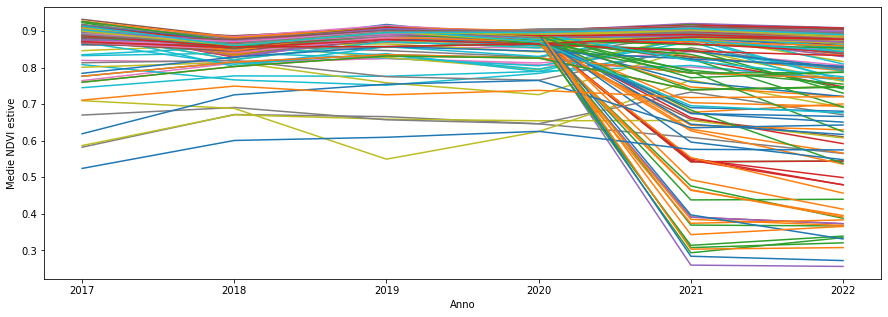

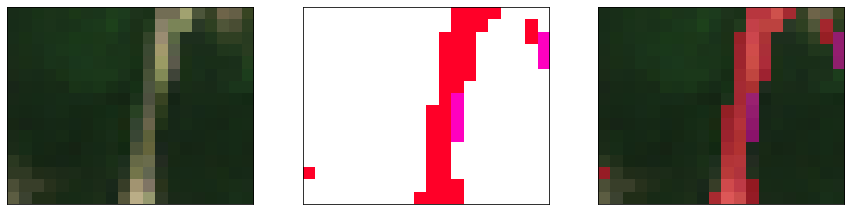

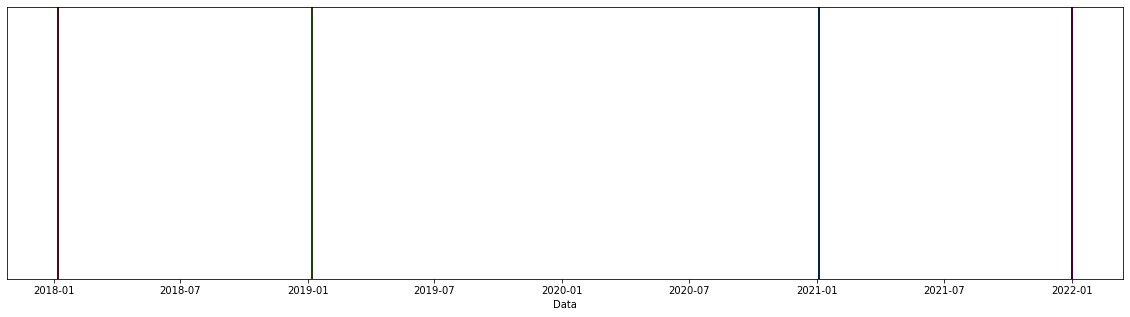

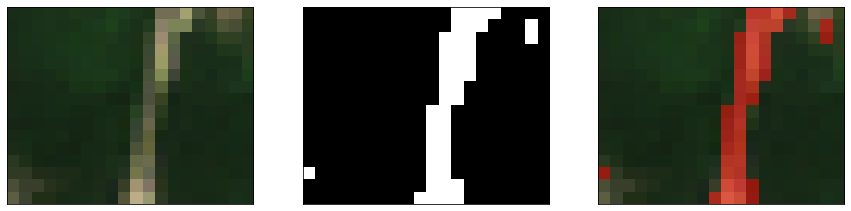

In [17]:
area = "faggeta_1"

height = 16
width = 20

change_thresh = 0.10
cluster_thresh = 0.8  # 0.0 - 1.
min_cluster_size = 10
only_drops = False
keep_max = False

img_df = load_dataset(area+"_"+str(height)+"_"+str(width)+".csv")

# ------------------------------------------------------------------------------
# ---------------------CHANGEPOINT DETECTION------------------------------------

peak_height = quantile_mean_change_detection(height, width, img_df, change_thresh,"05-01", "07-30", 0.9, keep_max, only_drops)
#peak_height = quantile_mean_change_detection(height, width, img_df, change_thresh,"04-01", "09-30", 0.85, keep_max, only_drops)
#peak_height = swmad_change_detection(height, width, img_df,  change_thresh, keep_max)

# ------------------------------------------------------------------------------
# ---------------------CHANGEPOINT CLUSTERING-----------------------------------
peak_height.sort(key=lambda x: x[0])
peak_height = np.asarray(peak_height)
peak_height[:, 0] = peak_height[:, 0].astype(int)

#show_results_all(area, peak_height[:,2:])

n_clusters, labels, centers = cluster1D_changepoints(peak_height[:,0], max_distance=3)
#n_clusters, labels = cluster_changepoints(peak_height[:,np.asarray([0,2,3])], 0.15, min_cluster_size, False)

# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------

show_results_clusters(area, labels, peak_height[:,2:])

# PRE - FILTER
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
plt.xlabel("Data")
colorHelper = MplColorHelper('gist_rainbow', 0, 1,)
clusters_data = []
for l in np.unique(labels):
  cluster_vals = peak_height[labels == l]
  plot_vlines(axs, img_df.loc[cluster_vals[:,0]]["date"], color=colorHelper.get_rgba(l/n_clusters))
  if cluster_vals.shape[0] >= min_cluster_size:
    clusters_data.append((cluster_vals[:,1].mean(), l))
plt.tick_params(left = False, right = False , labelleft = False )
plot_vlines(axs, img_df.loc[centers]["date"], color="black")
plt.show()

clusters_data.sort(key=lambda x: x[0], reverse=True)

# FINAL FILTER
max_mean = clusters_data[0][0]
filtered_clusters = []
for cd in clusters_data:
  if cd[0] >= cluster_thresh * max_mean:
    cluster_vals = peak_height[labels == cd[1]]
    coords = cluster_vals[:,2:]
    # Calculates the changepoint time as the average of the cluster changepoint dates
    changepoints = img_df.loc[cluster_vals[:,0]]["date"]
    mean = (np.array(changepoints, dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))
    changepoint =str(mean)[:10]
    filtered_clusters.append((coords, changepoint))
  else:
    break

#filtered = np.zeros((height,width))
for fc in filtered_clusters:
  filtered = np.zeros((height,width))
  for p in fc[0]:
    filtered[int(p[0]), int(p[1])] = 1
  show_results(area, filtered)
  #show_results_with_metrics(area, filtered)

# show_results(area, filtered)

# RESULTS WITH METRICS
#show_results_with_metrics(area, filtered)

## FORECASTING AND ASSESSMENT OF THE STATE OF RESTORATION
This section performs time series forecasting of previously detected pixels.

Set parameters to enable or disable normalization (norm and normlog).

Use cutoff = fc[1] to use the date of change calculated automatically in the previous cell. Otherwise set it manually by testing.

Finally depending on the model you intend to use set the parameters of the params dictionary correctly. See the sections on each model for the various parameters needed.

On line 53-54 select the method to calculate the restore state of each pixel. When finished, a gif will be generated showing the predicted restoration state over the forecasting period.

NUMBER:  44


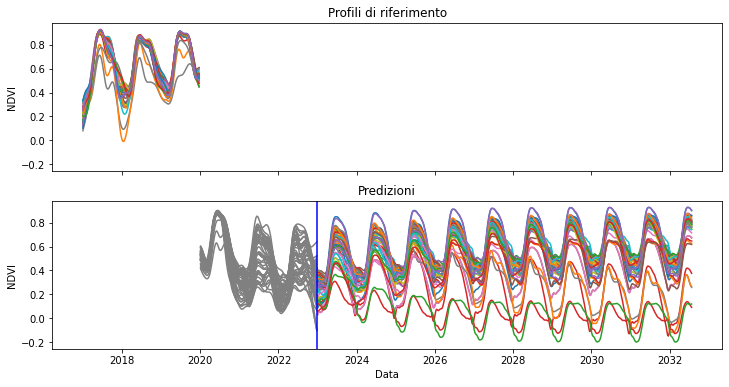

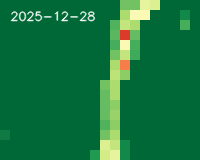

In [22]:
vplot = True #plot visualization
norm = False #enable normalization
normlog= False #normalize with log


for fc in filtered_clusters:
  #cutoff = fc[1] #Use this line 
  cutoff = "2020-01-01"
  changed_df = filter_ts_from_pixels(img_df, width, fc[0])
  series, pre, post, scalers = split_dataset(changed_df, cutoff, norm, normlog)

  periods = 500

  #trend_changepoints = [fc[1][:4]+"-02-10", fc[1][:4]+"-06-28"]
  trend_changepoints = ["2021-06-01"]

  params = {
    "yearly_seasonality": True,
    "n_changepoints": 5,
    "changepoints": trend_changepoints,
    "changepoint_range": 0.5,
    "changepoint_prior_scale": 10,
    "seasonality_prior_scale": 0.15,
    "growth":"logistic",
    "include_history": False,
    "cap": pre["0"].mean(),
    "floor": 0,
}

  
  references = changed_df.iloc[:52*3]

  model = "prophet"
  forecasts = multi_fit_predict(model, post, periods, norm, normlog, scalers, params)
  if vplot:
    f,axs=plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
    axs[0].set_title("Profili di riferimento")
    axs[1].set_title("Predizioni")
    axs[1].set_xlabel("Data")
    axs[1].set_ylabel("NDVI")
    axs[0].set_ylabel("NDVI")
    for i, forecast in enumerate(forecasts):
      axs[1].plot(forecast['ds'], forecast["yhat"])
      axs[1].plot(post["date"], post[str(i)], color="grey")
      axs[0].plot(references["date"], references[str(i)])
    axs[1].axvline(post["date"].iloc[-1], color="blue")
    plt.show()
  
  dates = pd.to_datetime(forecasts[0]["ds"])
  win = len(references.index)

  
  val = fpca_restore_point_pred(references, forecasts, 4)
  #val = naive_restore_point_pred(references, forecasts)
  
  
  img_array = []
  for k in range(0, val.shape[0]):
  #for k in [0, 50, 150, periods-win-1]:
    im_raw = rspt_results(val, fc, changed_df, k)
    im = cv2.resize(im_raw, dsize=(width*10, height*10), interpolation=cv2.INTER_NEAREST)
    im = np.uint8(cm.RdYlGn(im)*255)
    im = cv2.putText(im, dates.dt.strftime('%Y-%m-%d')[k+win], (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.4, (255, 255, 255), 1, cv2.LINE_AA)
    im = Image.fromarray(im)
    
    img_array.append(im)

    '''plt.title(dates.dt.strftime('%Y-%m-%d').iloc[k+win], {"fontsize": 20})
    plt.imshow(im_raw, cmap="RdYlGn")
    plt.colorbar()
    plt.show()'''


frame_one = img_array[0]
frame_one.save("result.gif", format="GIF", append_images=img_array,
               save_all=True, duration=10, loop=0)
Show("result.gif")



# TESTING

## CHANGE DETECTION TESTING

In [ ]:
veg = "faggeta_1_test.csv"
unscaled = load_dataset(veg)
#unscaled = unscaled.filter(["0", "date"])


# Equalize number of time serieses between test and control dataset
'''cn = len(unscaled_uw.columns)
tn = len(unscaled_h.columns)
mx = max([cn, tn])
mn = min([cn, tn])
diff = mx - mn
for i in range(diff):
  if cn == max:
    unscaled_uw = unscaled_uw.drop(columns={str(mn+i)})
  else:
    unscaled_h = unscaled_h.drop(columns={str(mn-2+i)})'''


changepoints = test_swmad(unscaled, 104, 0.2)
print(" N° changepoints ", len(changepoints))
# Find mean changepoint
mean = (np.array(changepoints, dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))


year_start = False
if year_start:
  construction_changepoint =str(mean)[:4]+"-01-01"
else:
  construction_changepoint =str(mean)[:10]
print(construction_changepoint)


(0.0, 1.0)

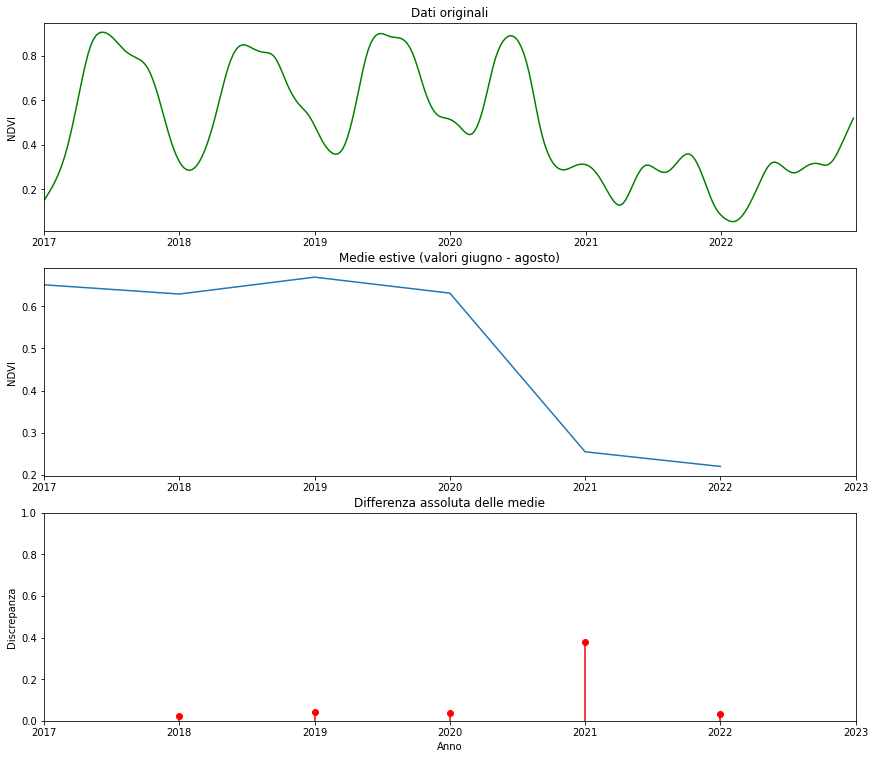

In [ ]:
val, jumps = fixed_summer_quantile_mean(unscaled["0"], unscaled["date"], "01-01", "09-30", None, False)
fig, axs = plt.subplots(3, 1, figsize=(12, 9))
plt.tight_layout()
plt.subplots_adjust(bottom=-0.1)
axs[0].set_title("Dati originali")
axs[0].set_ylabel("NDVI")
axs[0].set_xlim(pd.to_datetime(["2017-01-01", "2022-12-31"]))
axs[1].set_title("Medie estive (valori giugno - agosto)")
axs[1].set_xlim([2017, 2023])
axs[1].set_ylabel("NDVI")
axs[2].set_title("Differenza assoluta delle medie")
axs[2].set_xlim([2017, 2023])
axs[2].set_xlabel("Anno")
axs[2].set_ylabel("Discrepanza")
axs[0].plot(unscaled["date"], unscaled["0"], color="g")
axs[1].plot(val[0], val[1])
jumps = pd.DataFrame(jumps)
axs[2].vlines(jumps[0], 0, jumps[1], linestyles="solid", colors=["r"])
axs[2].scatter(jumps[0], jumps[1], color="r")
axs[2].set_ylim(0,1)


In [ ]:
def decompose_trends(df):
  i=0
  trend_df = df.copy()
  while str(i) in df.columns:
    stl = STL(df[str(i)], period=52, seasonal=25)
    res = stl.fit()
    trend_df[str(i)] = res.trend
    i+=1
  return trend_df

## FORECASTING TESTING

In [ ]:
vplot = True #plot visualization
norm = False #enable normalization
normlog= False #normalize with log

#cutoff = construction_changepoint
unscaled = unscaled.loc[unscaled['date'] >= "2021-01-01"]


cutoff = "2022-01-01"

series, train, test, scalers = split_dataset(unscaled, cutoff, norm, normlog, time_unit)


period = len(test.index)

trend_changepoints = ["2020-12-01","2021-01-01","2021-02-01"]

params_post = {
    "yearly_seasonality": True,
    "n_changepoints": 24,
    "changepoints": trend_changepoints,
    "extra_regressor": False,
    "changepoint_range": 1,
    "changepoint_prior_scale": 10,
    "seasonality_prior_scale": 0.1,
    "growth":"logistic",
    "include_history": False,
    "cap": "auto"
}

params_pre = {
    "yearly_seasonality": True,
    "n_changepoints": 25,
    "changepoints": None,
    "extra_regressor": False,
    "changepoint_range": 0.5,
    "changepoint_prior_scale": 0.1,
    "seasonality_prior_scale": 0.15,
    "growth":"logistic",
    "include_history": False,
    "cap": "auto"
}


params_np_pre = {
    "growth" : "linear",
    "n_changepoints" : 25,
    "changepoint_range" : 0.5,
    "trend_reg" : 1,
    "changepoints" : None,
    "include_history": False
}

params_np_post = {
    "growth" : "linear",
    "n_changepoints" : 6,
    "changepoint_range" : 1,
    "trend_reg" : 1,
    "changepoints" : trend_changepoints,
    "include_history": False
}

params_hwes = {
    "seasonal_periods" : 52,
    "include_history":False,
}

params_nbeats = {
    "backward_steps": 52,
    "forward_steps" : 10,
    "epochs" : 100,
    "batch_size": 5
}

params_lstm = {
    "backward_steps" : 52,
    "forward_steps": 15,
    "epochs" : 100,
    "batch_size": 5
}

model = "lstm"

forecasts_pre = multi_fit_predict(model, train, period, norm, normlog, scalers, params_lstm)
#forecasts_post = multi_fit_predict(model, test, period, norm, normlog, scalers, params_hwes)

mse_l = []
mae_l = []
mape_l = []
r2sc_l = []
if vplot:
  f,axs=plt.subplots(1, 1, figsize=(10, 4), sharex=True)
  for i in range(len(forecasts_pre)):
    ts = unscaled[str(i)]
    pred = forecasts_pre[i]
    axs.plot(unscaled['date'].loc[:test.index[0]], ts.loc[:test.index[0]] ,'blue')
    axs.plot(unscaled['date'].loc[test.index[0]:], ts.loc[test.index[0]:] ,'green', label="Ground Truth")
    axs.plot(pred['ds'], pred["yhat"], 'k-', color="orange", label="Predizione")
    MSE, MAE, r2score, MAPE = ts_metrics(ts.loc[test.index[0]:], pred["yhat"])
    mse_l.append(MSE)
    mae_l.append(MAE)
    mape_l.append(MAPE)
    r2sc_l.append(r2score)
    #print("MSE:", MSE, " MAE:", MAE, " r2score:", r2score, " MAPE:",MAPE)
  '''for forecast in forecasts_post:
    axs[1].plot(forecast['ds'], forecast["yhat"],'r-',)'''
       
  plt.title("HWES")
  print("MSE:", trimmed_mean(mse_l), " MAE:", trimmed_mean(mae_l), " MAPE:", trimmed_mean(mape_l), " r2score:", trimmed_mean(r2sc_l))
  plt.rc('xtick',labelsize=6)
  plt.ylabel("NDVI")
  plt.xlabel('Data')
  plt.legend()
  plt.axvline(pd.to_datetime(cutoff), color="b")
  #plt.axvline(series["date"].values[-1], color="r")
  plt.show()

  


In [ ]:
scores = fpca_scores_by_year(unscaled_uw)
fd = transform_to_fd(unscaled_uw)
# plt.plot(scores[:,3, :])
# axs[2].plot(scores[:,2,:])

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 15))
axs[1].set_title("FORECASTS")
axs[0].set_title("REFERENCE SET (FPCA FIT)")
axs[2].set_title("FPCA SCORES DIFFERENCE")

references = unscaled_uw.iloc[:len(train_uw.index)]
i = 0
x, val = fpca_scores_window_ref(references , forecasts_post, 3, shift=False, append=True)
while str(i) in unscaled_uw.columns:
  #axs[1].plot(forecasts_pre[i].index, forecasts_pre[i]["yhat"], color="b")
  axs[0].plot(references.index, references[str(i)], color="black")
  axs[1].plot(forecasts_post[i].index+len(train_uw.index), forecasts_post[i]["yhat"], color="r")
  i += 1

result = np.sum(np.abs(val), axis=1)
axs[2].plot(x, result)
avg = moving_average(result, 52)
axs[2].plot(avg)

## COMPARISON OF CHANGEPOINT DETECTION METHODS

In [ ]:
n_samples, n_dims, sigma = 1000, 1, 2
n_bkps = 6  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, n_dims, n_bkps, noise_std=sigma)

signal = pd.DataFrame(signal)                          
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(20, 20))
axs[0].plot(signal.index, signal[0])
plot_vlines(axs[0], bkps, "b")
axs[0].set_title("SIGNAL")

# Mean absolute difference between left half and right half of the window
axs[1].set_title("MEAN ABSOLUTE DIFFERENCE SLIDING WINDOW")
val = signal[0].rolling(100, center=True).apply(mean_diff)
axs[1].plot(val)
peaks, _ = find_peaks(val, distance=100)
plot_vlines(axs[1], peaks)

# Ruptures package, radial basis function
axs[2].set_title("RADIAL BASIS FUNCTION (Ruptures package)")
algo = rpt.Pelt(model="rbf").fit(signal[0].values)
val2 = algo.predict(pen=10)
plot_vlines(axs[2], val2)

# RULSIF
x, val3 = rulsif_scores(signal[0], 30, 1, 20, 10)
axs[3].plot(x, val3)
axs[3].set_title("RULSIF")
peaks, _ = find_peaks(val3, distance=50, height=10)
plot_vlines(axs[3], peaks+min(x))

# Mape between left half and right half of the window
'''axs[4].set_title("MAPE SPLIT WINDOW")
val4 = signal[0].rolling(20, center=True).apply(mape)
axs[4].plot(val4)
peaks, _ = find_peaks(val4, distance=100)
plot_vlines(axs[4], peaks)'''